In [32]:
import getpass
import os
import urllib.request
from glob import glob
from tqdm import tqdm
import bs4

from langchain.chat_models import init_chat_model
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_cohere import CohereEmbeddings

#from langchain.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter #splits based on common separators (new lines etc) 
from langgraph.graph import START, StateGraph

from langchain.document_loaders import DirectoryLoader


from typing_extensions import List, TypedDict

from langchain.document_loaders import UnstructuredPDFLoader
from langchain.indexes import VectorstoreIndexCreator


from langchain_community.document_loaders import PyPDFLoader
from pypdf import PdfReader
os.environ['USER_AGENT'] = 'myagent'



False

In [33]:
if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ") # have put API key in .env

model = init_chat_model("command-r-plus", model_provider="cohere")


In [4]:
model.invoke("Hello Command R+").content

'Hello! How can I help you today?'

In [11]:
model.invoke("What are you?").content

'I am an AI assistant chatbot trained to assist human users by providing thorough responses. I am designed to be helpful and harmless. I am powered by a large language model built by the company Cohere, and I am always learning and evolving based on my interactions and training data.'

# Adding the *R* in RAG step

Using the most recent openly available Cohere embedding model
(Instantiating an embedding: Taking an input (e.g. word or phrase) and passing it through an embedding model to obtain a vector representation.)
Embedding dimension of the following model is 1024. The embedding dimension is a hyperparameter
Embedding can also be performed on images, representing them as a numerical vector. This is done in CNNs

In [5]:

embeddings = CohereEmbeddings(model="embed-english-v3.0") 

# Initialize with an embedding model
vector_store = InMemoryVectorStore(embedding=embeddings)

In [6]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [47]:

# Load and chunk contents of the blog
#loader = WebBaseLoader(
#    web_paths=("websiteurlhere",),
#    bs_kwargs=dict(
#        parse_only=bs4.SoupStrainer(
#            class_=("article-content-redesign")
#        )
#    ),
#)

loader = WebBaseLoader(["https://services.swpc.noaa.gov/text/discussion.txt"])

docs = loader.load()
print(f"Total characters: {len(docs[0].page_content)}")



text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
all_splits = text_splitter.split_documents(docs)
print(f"Split content into {len(all_splits)} sub-documents.")


# Index chunks
_ = vector_store.add_documents(documents=all_splits) # vector embedding
print(_[:3])

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Retrying langchain_cohere.embeddings.CohereEmbeddings.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised TooManyRequestsError: status_code: 429, body: {'message': 'trial token rate limit exceeded, limit is 100000 tokens per minute'}.


Total characters: 2425
Split content into 19 sub-documents.


Retrying langchain_cohere.embeddings.CohereEmbeddings.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised TooManyRequestsError: status_code: 429, body: {'message': 'trial token rate limit exceeded, limit is 100000 tokens per minute'}.


TooManyRequestsError: status_code: 429, body: {'message': 'trial token rate limit exceeded, limit is 100000 tokens per minute'}

Always remember to implement callbacks to log, monitor, and stream specific events and detect issues within operations

In [51]:
print(docs[0].page_content[:500])

:Product: Forecast Discussion
:Issued: 2025 Mar 22 1230 UTC
# Prepared by the U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center
#
Solar Activity

.24 hr Summary...
Solar activity reached moderate levels. Region 4028 (S16W38, Cai/beta)
produced an M1.2/1n flare at 21/1534 UTC accompanied by a Type-II radio
sweep with an estimated velocity of 334 km/s. Region 4033 (N19W33,
Axx/alpha) reemerged as simple spots. Region 4036 (N07W38,
Dai/beta-gamma) underwent evolution as it quickly gaine


In [59]:
response = graph.invoke({"context": "space weather", "question": "what is the likelyhood of geomagnetic activity in the next 24 hours and what could be causing it?"})
print(response["answer"])

Geomagnetic storming is likely on March 24, caused by lingering CME and negative polarity CH HSS effects.


In [7]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [61]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [63]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

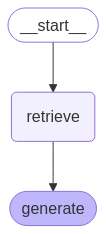

In [64]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# getting all the pdfs
import arxiv

# Construct the default API client.
client = arxiv.Client()
query = "solar AND coronal mass ejections AND radio NOT neutron stars NOT fast radio bursts"
search = arxiv.Search(
    query=query,
    max_results=5,
    sort_by=arxiv.SortCriterion.SubmittedDate,
    sort_order=arxiv.SortOrder.Descending
)
filepaths = []
# Fetch and display results
for result in search.results():
    #print(f"Title: {result.title}")
    #print(f"Authors: {', '.join(author.name for author in result.authors)}")
    #print(f"Published: {result.published.year}")
    #print(f"Summary: {result.summary[:500]}...")  # Truncated for readability
    #print(f"Link: {result.entry_id}")
    #print(f"PDF Link: {result.pdf_url}\n")
    
    lastname = str(result.authors[0]).split(' ')[-1]
    year_pub = str(result.published.year)

    url = str(result.pdf_url)
    filepaths.append(url)

    file_name = "research_papers/" + lastname + year_pub + '.pdf'
    print(file_name)
    urllib.request.urlretrieve(url, file_name)
    


/var/folders/vd/hmh1fhyd2278mtdx22m1mvk00000gn/T/ipykernel_1528/2355810110.py:15: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


http://arxiv.org/pdf/2503.13876v2
http://arxiv.org/pdf/2502.16934v1
http://arxiv.org/pdf/2502.15066v1
http://arxiv.org/pdf/2412.15961v1
http://arxiv.org/pdf/2412.06477v1


In [93]:

embeddings = CohereEmbeddings(model="embed-english-v3.0") 

# Initialize db with an embedding model
vector_db = Chroma(collection_name="research_papers", embedding_function=embeddings)

#vector_store = InMemoryVectorStore(embedding=embeddings)

In [8]:
directory = "/Users/jeremy/Documents/Machine Learning/research_papers/"

def extract_text(pdf_path):
    """Extract text from a PDF."""
    reader = PdfReader(pdf_path)
    text = ''
    for page in reader.pages:
        text += page.extract_text() or ''
    return text

from langchain.document_loaders import DirectoryLoader



#for item_path in glob(directory+"*.pdf"):
    #print(item_path)
    #loader = PyPDFLoader(item_path, mode='single', pages_delimiter="\n-------THIS IS A CUSTOM END OF PAGE-------\n",)
    #docs = loader.load()


loader = DirectoryLoader('./research_papers/', glob="./*.pdf", loader_cls=PyPDFLoader)

docs = loader.load()

# Split text for embedding
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
all_splits = text_splitter.split_documents(docs)
print(len(all_splits))
print(texts[2])
# Embed and add to vector database

    #vector_db.add_texts(texts, embedding)
    #vector_db.add_documents(documents=all_splits)

#print("All PDFs processed and vectorized!")


#docs = loader.load()
#print(f"Total characters: {len(docs[0].page_content)}")



#text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
#all_splits = text_splitter.split_documents(docs)
#print(f"Split content into {len(all_splits)} sub-documents.")


250


NameError: name 'texts' is not defined

In [9]:
directory = "/Users/jeremy/Documents/Machine Learning/research_papers/"


loader = DirectoryLoader('./research_papers/', glob="./*.pdf", loader_cls=PyPDFLoader)

docs = loader.load()

# Split text for embedding
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
all_splits = text_splitter.split_documents(docs)
print(len(all_splits))
print(all_splits[2])


250
page_content='(CMEs). The MHD shocks accelerate electrons to high speeds which excite Langmuir waves,
eventually resulting in plasma emissions at the fundamental (F) and harmonic (H) of the local
plasma frequency (McLean & Labrum 1985). Type-II emissions have been observed from
metric (m-), decametric (Dm-) to kilometric (km-) wavelengths arising over a wide range of
coronal heights and interplanetary medium. Association with shocks of large-scale solar erup-
tions makes studying type-IIs extremely attractive from the perspective of understanding space
weather, particularly for determining solar energetic particle (SEP) events. Several studies have
concluded that metric type-IIs mostly originate from CME-driven shocks (e.g., Gopalswamy
2006; Kumari et al. 2023) and hence can be used to understand the energetics, kinematics, and
dynamics of the shocks produced by the CMEs.
Type-II bursts often appear as two (F and H) slowly drifting bands (with a typical drift rate' metadata={'produ

In [10]:
persist_directory = 'db'

embedding = CohereEmbeddings(model="embed-english-v3.0") 

# embed and add to vector db
vector_db = Chroma.from_documents(documents=all_splits, embedding=embedding, persist_directory=persist_directory)


In [11]:
# Load persisted db from disk
vector_db = Chroma(persist_directory=persist_directory, embedding_function=embedding)


In [12]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_db.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [16]:
response = graph.invoke({ "context":"solar physics", "question": "Give me a summary of the Morosan 2025 paper"})
print(response["answer"])

I don't know.


In [34]:

loaders = []

for item_path in glob(directory+"*.pdf"):
    loader = PyPDFLoader(item_path)
    loaders.append(loader)

docs = []
for loader in loaders:
    docs.extend(loader.load())
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)
docs = text_splitter.split_documents(docs)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="full_documents", embedding_function=embedding)

In [35]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

In [36]:
# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

In [37]:
retriever.vectorstore.add_documents(sub_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [38]:
retriever.vectorstore.similarity_search("coronal mass ejection")[0]



Document(id='3fd5dac8-619f-41a8-a1e3-350959717c4b', metadata={'author': '', 'creationdate': '2024-12-10T02:36:26+00:00', 'creator': 'LaTeX with hyperref', 'doc_id': '051e7a25-0094-4e1d-a9da-7f743e9055cc', 'keywords': '', 'moddate': '2024-12-10T02:36:26+00:00', 'page': 0, 'page_label': '1', 'producer': 'pdfTeX-1.40.25', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'source': '/Users/jeremy/Documents/Machine Learning/research_papers/Morosan2024.pdf', 'subject': '', 'title': '', 'total_pages': 12, 'trapped': '/False'}, page_content='Flares are often associated with coronal mass ejections\n(CMEs), which can also energize electrons whose signatures\nare observed concurrently with those related to flare-accelerated\nelectrons (e.g., Jebaraj et al. 2023b; Morosan et al. 2024). These\nelectrons are accelerated by quasi-perpendicular CME-driven\nshock waves to energies up to a few tens of keV (Mann &')

In [39]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = retriever.vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [45]:
response = graph.invoke({ "context":"solar physics", "question": "What was the drift rate of the Type II observed on 3 October 2023"})
print(response["answer"])

I don't know.


In [138]:
len(retriever.invoke("coronal mass ejection")[0].page_content)



5696

In [139]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("command-a-03-2025", model_provider="cohere")



In [152]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

In [154]:
summaries = chain.batch(docs, {"max_concurrency": 50})

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<loc

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [165]:
from langchain_core.runnables import RunnablePassthrough


def format_docs(sub_docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("Describe the shock expansion from the Morosan 2025 paper"):
    print(chunk, end="", flush=True)

The Morosan 2025 paper isn't mentioned in the provided context.  Therefore, I cannot describe the shock expansion from that paper.  Please provide the relevant context.

In [151]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)
llm.invoke("Sing a ballad of LangChain.")

AIMessage(content="(Verse 1)\nIn silicon valleys, where code weaves its spell,\nA new tool arose, its story to tell.\nLangChain, they called it, a chain forged with care,\nTo link language models, beyond compare.\nNo longer confined, to a singular mind,\nBut woven together, a new breed to find.\n\n(Verse 2)\nFrom OpenAI's forge, and others so grand,\nThese models emerged, a powerful band.\nBut each on its own, a limited scope,\nLangChain arrived, with a message of hope.\nIt bridged the divide, with chains strong and true,\nUnlocking potential, in all that they do.\n\n(Verse 3)\nWith agents so clever, and tools sharp and keen,\nLangChain could access, what lay unseen.\nFrom databases vast, to the web's endless store,\nIt gathered the knowledge, and craved evermore.\nIt reasoned and planned, with a logical grace,\nAnd answered our queries, with nary a trace\nOf the complex workings, that hummed deep inside,\nWhere language models, in harmony reside.\n\n(Verse 4)\nThe developers toiled, w

In [147]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key:  ········


In [48]:
query = "What are coronal mass ejections"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

Solar flares and associated coronal mass ejections are sources of space weather that ad-
versely impact devices at or near Earth, including the obstruction of high-frequency ra-
dio waves utilized for communication and the deterioration of power grid operations.
Tracking and delivering early and precise predictions of solar flares is essential for readi-
